# Video frame PCA
This notebook will walk you through doing PCA on images in the VEDB data. We will perform PCA on the same sort of stack of images as we did in a prior notebook, but this time the stack of images will be from the same video, such that we can look at the timecourses of the projections of each frame onto the first few PCs! If this all sounds mysterious, stay tuned and play along. 

This notebook is meant to be open-ended; you can change many of the parameters in it to explore different movies. We hope this will provide some inspiration for a potential final project!

In [38]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
# PCA code
from sklearn.decomposition import PCA
# VEDB code
import file_io
import plot_utils
%run ~/Code/summer_workshop/code/vedb_utils.py
# Fancy display code
from IPython.display import HTML

Choose a session to examine. Stick with the one shown here first. 

In [39]:
# Get a list of all sessions in alphabetical order
session_folders = sorted(glob.glob('/home/data/vedb/*'))
session_folders

['/home/data/vedb/2020_09_28_20_53_15',
 '/home/data/vedb/2020_10_19_00_23_14',
 '/home/data/vedb/2021_01_11_16_33_39',
 '/home/data/vedb/2021_02_01_23_53_59',
 '/home/data/vedb/2021_02_08_16_24_36',
 '/home/data/vedb/2021_02_22_10_35_01',
 '/home/data/vedb/2021_02_22_20_40_52',
 '/home/data/vedb/2021_02_25_16_28_15',
 '/home/data/vedb/2021_03_04_17_01_45',
 '/home/data/vedb/2021_03_04_22_37_35',
 '/home/data/vedb/2021_03_14_14_13_55',
 '/home/data/vedb/2021_04_11_09_26_11',
 '/home/data/vedb/2021_05_15_10_30_33']

In [40]:
# Choose this one first.
session_folder = session_folders[1]

In [41]:
# Load the session object for loading other streams
ses = Session(folder=session_folder)

In [42]:
# Check out how long it is:
ses.recording_duration

1078.6836640469264

In [43]:
# How long is that in minutes?
ses.recording_duration / 60
# ... short!

17.978061067448774

In [44]:
# Load one minute worth of data. This is a fair bit,
# of data, and may take a while! Note that we are loading this
# at fairly low resolution (much smaller than it was originally
# captured)
timestamps, frames = ses.load('world_camera', time_idx=(120, 180), size=(30,40), color='rgb')

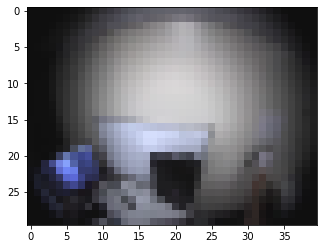

In [45]:
# Have a look at the first frame:
plt.imshow(frames[0])

In [46]:
# Reshape this array to ravel out all the RGB pixels 
# along the second dimension, keeping time as the first
# dimension!
frames_array = frames.reshape(frames.shape[0], -1)
print(frames_array.shape)

(1718, 3600)


Let's do a quick check on how large our variables are:

In [10]:
%whos

Variable          Type       Data/Info
--------------------------------------
HTML              type       <class 'IPython.core.display.HTML'>
OrderedDict       type       <class 'collections.OrderedDict'>
PCA               ABCMeta    <class 'sklearn.decomposition._pca.PCA'>
Session           type       <class '__main__.Session'>
datetime          module     <module 'datetime' from '<...>b/python3.7/datetime.py'>
file_io           module     <module 'file_io' from '/<...>egg/file_io/__init__.py'>
frames            ndarray    1479x30x40x3: 5324400 elems, type `uint8`, 5324400 bytes (5.0777435302734375 Mb)
frames_array      ndarray    1479x3600: 5324400 elems, type `uint8`, 5324400 bytes (5.0777435302734375 Mb)
glob              module     <module 'glob' from '/hom<...>p/lib/python3.7/glob.py'>
np                module     <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
os                module     <module 'os' from '/home/<...>hop/lib/python3.7/os.py'>
plot_utils        module  

Set up PCA with scikit-learn as we have done before:

In [47]:
# We will only look at 10 PCs for now
pca = PCA(n_components=10)

In [48]:
pca.fit(frames_array)

PCA(n_components=10)

## Results of PCA
First things first: always look at a scree plot to see how much variance each PC in the data explains:

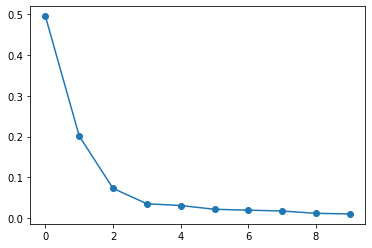

In [49]:
plt.plot(pca.explained_variance_ratio_, 'o-')

Looks like there is one fairly big PC - OK! Now, since these components - or axes of the space - are all in the pixel domain, we can visualize what the PC looks like! However, we have to re-shape the pixels back into their image shape, and the scale of the values will be all wrong to view this as an RGB image. So we have a bit of adjustment to do. 

This might sound shady to you, but for PCs, we are mostly interested in the relative size of the values, not their absolute magnitude. So as long as we add, subtract, or multiply all values by the same scalar quantity, relative values will be preserved. 

In [50]:
# Get the first component 
pc0 = pca.components_[0].copy()

In [51]:
# Pre-check on value:
pc0.min(), pc0.max()

(-0.14239228931550046, 0.13631343421347275)

In [52]:
# Rescale the values to 0-1 by subtracting the min and dividing 
# by the range (np.ptp computes the range for the whole array)
pc0_rescaled = (pc0 - pc0.min()) / np.ptp(pc0)

In [53]:
# Prove to yourself that this is what we've done:
pc0_rescaled.min(), pc0_rescaled.max()

(0.0, 1.0)

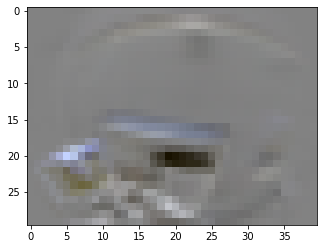

In [54]:
# Get size of original frames...
image_size = frames.shape[1:]
pc0_as_image = pc0_rescaled.reshape(image_size)
plt.imshow(pc0_as_image)

What is this? Let's look through the clip we pulled to see if anything resembles this:

In [55]:
# Get average frame rate - remember, it's not always exactly 30 for 
# VEDB data.
mean_fps = 1 / np.mean(np.diff(timestamps).mean())
print(mean_fps)

28.63132134611106


In [56]:
# Make an animation of the frames for which we computed PCA
# A note: figsize governs the aspect ratio of the movie
anim = plot_utils.make_image_animation(frames, 
                                       figsize=(4,3), 
                                       fps=mean_fps, )
HTML(anim.to_html5_video())

# Look at timecourses of PCs

In [57]:
# Compute the projection of each frame onto each of the first 
# 10 pcs
pc_timecourses = pca.transform(frames_array)
# This gives an array that is of shape (time x PCs)
print(pc_timecourses.shape)

(1718, 10)


The result will show you "how much" of each PC there was in each frame. See if you can match the rise in the graph below with anything that is happening in the movie. 

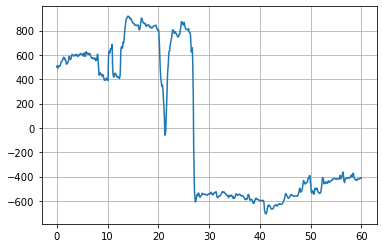

In [58]:
# Plot the first PC against time.
clip_time = timestamps-timestamps[0]
plt.plot(clip_time, pc_timecourses[:,0])
plt.grid('on')

# Try this on other data!

Pick a session folder, convert it to a session, and load it below, like this:

You will need to reshape the frames variable as we do above, and then Compute PCA as above, too. Once you have a similar `pca` object (you can call it whatever you like), you can pass that to the following functions to make quick work of the above cells! 

In [27]:
this_session = session_folders[5] # Fill this in!
ses = Session(folder=this_session)
start_time = 120 # in seconds
end_time = 180 # in seconds
downsampling_size = (30,40) # Keep this small!
color_mode = 'rgb' # Try 'gray' too, maybe! 
timestamps, frames = ses.load('world_camera', 
                              time_idx=(start_time, end_time), 
                              size=downsampling_size, 
                              color=color_mode)

# Compute PCA
pca_01 = PCA(n_components=10)
pca_01.fit(frames.reshape(frames.shape[0], -1))

PCA(n_components=10)

In [29]:
def show_pc(pca, component_number, image_size=(30,40,3)):
    pc = pca.components_[component_number]
    if len(image_size) == 3:
        pc_rescaled = (pc - pc.min()) / np.ptp(pc)
        plt.imshow(pc_rescaled.reshape(image_size))
    else:
        mx_val = np.maximum(np.abs(pc.max()), np.abs(pc.min()))
        plt.imshow(pc.reshape(image_size), vmin=-mx_val, vmax=mx_val, cmap='RdBu_r')
    
def plot_pc_timecourse(pca, component_number, frames):
    pc_timecourses = pca.transform(frames.reshape(frames.shape[0], -1))
    plt.plot(pc_timecourses[:,component_number])

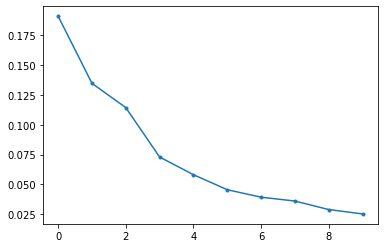

In [33]:
plt.plot(pca_01.explained_variance_ratio_, '.-')

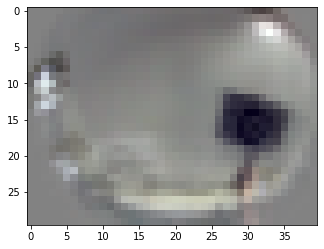

In [30]:
show_pc(pca_01, 0)

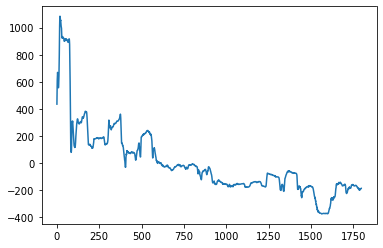

In [34]:
plot_pc_timecourse(pca_01, 0, frames)